In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/data'

/content/gdrive/My Drive/data


In [ ]:
!pip install tldextract

In [ ]:
import numpy as np
import pandas as pd
import re
import logging
import glob
import os
import torch
import tldextract
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns 
from urllib.parse import urlparse
from urllib.parse import unquote



In [ ]:
path2=r"/content/gdrive/My Drive/tld"

In [ ]:
path = r'/content/gdrive/My Drive/data'                     # use your path
all_files = glob.glob(os.path.join(path, "*.parquet"))
#logger = set_logger("./log/data.log")

**1**-  Data


In [ ]:
logging.basicConfig(level=logging.WARNING)

def load_dataset(path):
  "Read all files in the dataset and convert them into a dataframe"
  all_files = glob.glob(os.path.join(path, "*.parquet"))
  if not all_files:
        raise ValueError('The folder is empty. Please enter another path')
  df_from_each_file = (pd.read_parquet(f, engine='pyarrow') for f in all_files)
  concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
  logging.info("Data loaded successfully")

  return concatenated_df

In [ ]:
df=load_dataset(path)

2- Exploratory Data Analysis

In [ ]:
def duplicated(df,mode):
  """Deal with duplicated rows"""
  #The dataset contains two types of duplications: 1/ the url and the target are duplicated  2/the url is duplicated with different targets
  #to take into account the recent day
  if mode=="last":
    df_no_dup=df.drop_duplicates(subset=["url"],keep="last", inplace=False)
  # to take into account take the intersection between the different targets of same url
  if mode=="intersection":
     df["target"]=df["target"].apply(set)
     df_no_dup=pd.DataFrame(df.groupby('url',as_index=True)["target"].agg(lambda x:set.intersection(*x)))
     df_no_dup.reset_index(level=0, inplace=True)
     df_no_dup["target"]=df_no_dup["target"].apply(list)
  return df_no_dup


In [ ]:
logging.basicConfig(level=logging.WARNING)

def EDA(df,mode):
  " Function for Exploratory Data Analysis of Tags feature"
  """ 
    :param df: Dataframe
    :param mode: Method to remove the duplicate entries
    :return: Dataframe with no duplication
  """
  #remove missing data
  if df['target'].isnull().any():
    df=df.dropna(subset=['target'])

  labels=df["target"]
  #Number of unique labels
  count=len(set(labels.explode()))
  print(count)
  logging.info("Number of lables",count)
  logging.info("Number of rows in the dataset",len(df))

  #Checking for duplicate entries in the dataset
  boolean = df.duplicated(subset=['url']).any()

  if boolean:
    
    df_new= duplicated(df,mode="last")
    logging.info("Number of rows in the de-duplicated dataset",len(df_new))
    print("Total number of duplicate entries removed from the given dataset: ",len(df)-len(df_new))
  else:
    df_new=df

  #Checking for the distribution of number of tags per url
  df_new["tag_count"] = df_new["target"].apply(lambda tags: len(tags))
  plt.figure(figsize=(10,5))
  sns.countplot(df_new.tag_count, palette='gist_rainbow')
  plt.title("Distribution of the number of tags per url")
  plt.xlabel("Number of Tags")
  plt.ylabel("Number of url")
  plt.show()
  #Average of labels per url
  avg_tg=sum(df_new["tag_count"])*1/len(df_new["tag_count"])
  logging.info("Average  number  labels per url",avg_tg)
  logging.info("Max number of labels per url",max(df_new["tag_count"]))
  logging.info("Min number of labels per url",min(df_new["tag_count"]))

  #The number of times each tag appeared
  count=df_new["target"].explode().value_counts()
  plt.hist(count)
  plt.show()

  #drop column day and tag_count
  df_new=df_new.drop(["day",'tag_count'],axis=1)

  return df_new


1903
Total number of duplicate entries removed from the given dataset:  120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


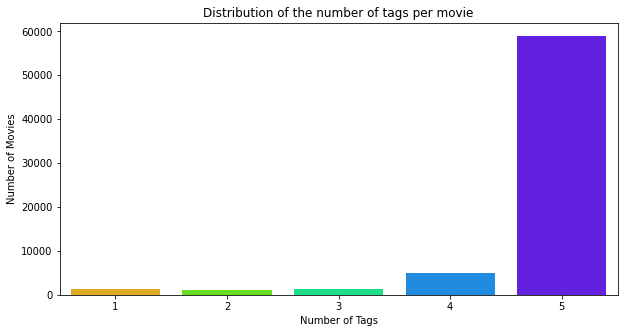

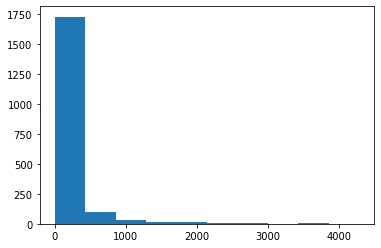

In [ ]:
d=EDA(df,"last")

In [ ]:
cd '/content/gdrive/My Drive/tld'

/content/gdrive/My Drive/tld


3- clenad data

In [ ]:
import nltk


In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_stopwords_and_tokens(sentence):
  """
  Remove stopwords from sentence and length less than 2
  """
  stopwords_list=stopwords.words('french')
  tokens = sentence.split(" ")
  tags=["html","php","htm","phtml"]
  tokens_filtered= [word for word in tokens if (not word in stopwords_list) and  (len(word)>2) and (not word in tags)]
  return (" ").join(tokens_filtered)

In [ ]:
def clean_path(path):
  """
  Clean path: remove stopwords, punctations, digits, token with length<2, espace
  """


  #remove puntation and digits
  path=re.sub(r'[^\w\s]|[0-9]', ' ', path)

  #remove stopwords:
  path=remove_stopwords_and_tokens(path)

  #remove extra space
  path=" ".join(path.split())

  return path
  

  

In [ ]:
def parse_url_clean(df):
  """ 
    Function for parsing  and cleaning the url
    :param df: Dataframe
    :return: Dataframe with new columns as features
  """
 
  #1.Parse path
  df["Path"]=df["url"].apply(lambda x:  urlparse(x).path)
  # Decode the path
  df["Path"]=df["Path"].apply(lambda x:  unquote(x))
  #Clean path
  df["Path"]=df["Path"].apply(lambda x:  clean_path(x))

  
  #3: Parse tld 
  #extract tld
  df['tld'] = df['url'].apply(
        lambda x: tldextract.extract(x).suffix ) # We consider only the last part of the tld
   #1/ parse and preprocessing of netloc
  #extract name of domain name
  df["Netloc"]=df['url'].apply(
        lambda x: urlparse(x).netloc)
  #remove wwww and tld from netloc
  url = re.compile(r"(www)?[\.]")
  df["Netloc"]= df["Netloc"].apply(lambda x: url.sub(' ',x).strip())
  df["Netloc"]= df.apply(lambda x:  x.Netloc.replace(x.tld, ""),axis=1 )

  
  return df


In [ ]:
df_features=parse_url_clean(d)



4-extract features

In [ ]:
def load_tld_files(path=path2):
    """ 
    Load files contained tld and their types
    Param path
    Return dict with tld as keys and type as value
    """
    tld = pd.read_csv(path+"/"+"tld-list-details.csv")
    gtld=pd.read_excel(path+"/"+"gtld.xlsx")
    gtld_dict=dict(zip(gtld.TLD, gtld.Catégorie))
    tld_dict = dict(zip(tld.TLD, tld.Type))

    return gtld_dict,tld_dict

In [ ]:
def tld_category(tld):
  """ 
  Param tld: top level domain
  Return the category of the top level domain
  """
  if tld.upper() in gtld_dict:
    return gtld_dict[tld.upper()]
  elif tld in tld_dict:
    return  tld_dict[tld]
  else:
    return "other_tld"

In [ ]:
gtld_dict,tld_dict=load_tld_files(path2)

In [ ]:
def extract_features(df):
  """ 
   Function for feature engineering: extract features from url
  
    :param df: Dataframe
    :return: Dataframe with new columns as features
  """
  df_features = df.copy()
  #extract length of url
  length_url_median = df_features['url'].apply(len).median()
  df_features['is_long'] = df_features['url'].apply(
        lambda x: len(x) > length_url_median).astype(int)

  #extract tld
  df_features["tld_category"]= df_features["tld"].apply(lambda x:tld_category(x))
  
  return df_features
    
  
  
  


In [ ]:
a=extract_features(df_features)

In [ ]:
def input_classifier(df)
""" 
Transform columns of the datafram to the right form for the classifier
"""

#Concatane the embedding of netloc and the path
embedding_path =


T5albiizz houni 


In [ ]:
for i in df["url"][:100]: 
  print(i)

https://www.cdiscount.com/bricolage/electricite/batterie-plomb-6v-4ah-ova51023e-pour-toplux/f-16614-ova2009927775303.html
https://www.mystalk.net/profile/vitoriafcorrea
https://www.lequipe.fr/Tennis/TennisFicheJoueur1500000000003017.html
http://m.jeuxvideo.com/forums/42-32625-60180057-1-0-1-0-la-guilde-fourmi-legionnaire-recrute.htm
https://context.reverso.net/traduction/espagnol-francais/Para+ir
https://www.nordeclair.fr/700287/article/2020-01-25/roubaix-les-panneaux-solaires-installes-sur-la-mediatheque-n-etaient-pas
https://www.750g.com/gateau-breton-de-mamie-scarlett-r70200.htm
http://www.jeuxvideo.com/forums/1-18505-21783-1-0-1-0-duree-de-vie.htm
https://www.lachainemeteo.com/meteo-france/ville-774900/previsions-meteo-tourtour-vendredi
https://fr.shopping.rakuten.com/s/lauren+st+john
http://m.jeuxvideo.com/forums/42-28979-59900574-1-0-1-0-la-configuration-pc.htm
http://mamiehiou.over-blog.com/article-ne-expletif-quand-peut-on-l-employer-sans-que-je-ne-avant-que-je-ne-je-crains-que

In [ ]:
class TextDataset(Dataset):
    def __init__(self,path):
        self.data = load_dataset(path)
        self.text=self.data.url
        self.labels=self.data.target
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
            label = self.labels[idx]
            text = self.text[idx]
            sample = {"Text": text, "Class": label}
            return sample

In [ ]:
def collate_batch(batch):
    word_tensor = torch.tensor([[1.], [0.], [45.]])
    label_tensor = torch.tensor([[1.]])
    
    text_list, classes = [], []
    for (_text, _class) in batch:
        text_list.append(word_tensor)
        classes.append(label_tensor)
    text = torch.cat(text_list)
    classes = torch.tensor(classes)
    return text, classes

In [ ]:
u

'http://1000-idees-a-faire-chez-soi-com.over-blog.com/2017/04/affiches-pour-apprendre-les-chiffres-de-1-a-10-a-imprimer-gratuitement.html'

In [ ]:
from urllib.parse import urlparse

In [ ]:
from url_normalize import url_normalize
u = urlparse(b)

In [ ]:
if __name__ == "__main__":
  urls_dataset = TextDataset(path)
  urls_dataloader = DataLoader(urls_dataset, batch_size=2 ,shuffle=True ,collate_fn=collate_batch)
  print('\nFirst iteration of data set: ', next(iter(urls_dataset)), '\n')

  # Print how many items are in the data set
  print('Length of data set: ', len(urls_dataset), '\n')

  # Print entire data set
  print('Entire data set: ', list(DataLoader(urls_dataset,collate_fn=collate_batch)), '\n')
  for index, batch in enumerate(urls_dataloader):
      
      # Print the 'text' data of the batch
      print(index, 'Text data: ', batch)
      # Print the 'class' data of batch
      print(index, 'Class data: ', batch, '\n')


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-19-f37367f5de06>(4)<module>()
      3   ipdb.set_trace()
----> 4   urls_dataloader = fixed_length_dataloader(urls_dataset, num_workers=4)
      5   now_time = time()

--KeyboardInterrupt--
*** NameError: name 'k' is not defined
4
--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
*** Newest frame
*** SyntaxError: invalid syntax
*** Newest frame
--KeyboardInterrupt--
--KeyboardInterrupt--


Pipeline 1

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
yt = mlb.fit_transform(y)

NameError: ignored